In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import folium
import imp
import mpld3
from sqlalchemy import create_engine
sn.set_context('notebook')

# RESA2 Arctic river data

## 1. Check for stations

Nikolai has some biological monitoring sites in the Arctic and he'd like to know if we have any additional environmental data for these locations. See e-mail received 04/03/2017 at 16.32 for details. The locations of interest are:

 * Altaelva
 * Halselva
 * Komagelva
 * Neiden
 * Tana
 * Beiearelva
 * Roksdalsvassdraget (Åelva)
 * Saltdalselva
 * Skjoma
 * Målselva
 * Reisaelva
 * Salangselva

Without unique station codes, these rivers may be difficult to identify. This notebook searches the database for any matches (including partial matches) based on the site names and pulls out some basic site properties.

In [13]:
# Create db connection
r2_func_path = r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template\useful_resa2_code.py'
resa2 = imp.load_source('useful_resa2_code', r2_func_path)

engine, conn = resa2.connect_to_resa2()

In [14]:
# Nikolai's site names of interest
# Names with special characters are duplicated for searching
stn_names = [u'Altaelva',
             u'Halselva',
             u'Komagelva',
             u'Neiden',
             u'Tana',
             u'Beiearelva',
             u'Roksdalsvassdraget (Åelva)',
             u'Roksdalsvassdraget (Aelva)',
             u'Roksdalsvassdraget',
             u'Åelva',
             # u'Aelva', # Remove - too many incorrect matches!
             u'Saltdalselva',
             u'Skjoma',
             u'Målselva',
             u'Malselva',
             u'Reisaelva',
             u'Salangselva']

In [15]:
# Search database

# Container for output
df_list = []

# Loop over names
for stn in stn_names:
    # Get stn matches
    sql = ("SELECT station_id, station_code, station_name, "
           "lake_or_river, latitude, longitude FROM RESA2.STATIONS "
           "WHERE LOWER(station_name) LIKE '%%%s%%'" % stn.lower())
    
    df = pd.read_sql_query(sql, engine)
    
    df_list.append(df)

# Combine results
stn_df = pd.concat(df_list, axis=0)

# Decode special characters
for col in stn_df.columns:
    if stn_df[col].dtype == object:
        stn_df[col] = stn_df[col].str.decode('windows-1252')

# Tidy
stn_df['station_id'] = stn_df['station_id'].astype(int)
stn_df.reset_index(inplace=True, drop=True)

stn_df

,station_id,station_code,station_name,lake_or_river,latitude,longitude
0,15956,ALTA-E 11,Altaelva v/Gøngæsholmen,R,69.837000,23.457000
1,15957,ALTA-E 12,Altaelva v/Killistraumen,R,69.913000,23.287000
2,29779,FINEALT,Altaelva,R,69.900992,23.286977
3,30033,FINENEI,Neidenelva,R,69.691992,29.369979
4,1629,FIN-855,UUTTANA,L,62.062000,25.012000
5,29820,FINETAN,Tanaelva,R,70.229993,28.173988
6,21082,OVELV 86 1,Tana v/Tana bru,None,70.200261,28.196080
7,21077,OVELV 81 1,Saltdalselva,None,67.047149,15.388531
8,30118,TROEREI,Reisaelva,R,69.764991,21.017979
9,21080,OVELV 84 1,Reisaelva,None,69.747004,21.096134


The search identifies 12 stations, most of which are fairly northern (although `UUTTANA` is not within the Arctic Circle and is probably an incorrect match). There are also some duplicated names with very similar co-ordinates, but different station codes. **Check this**.

The map below shows the locations of these 12 sites. Click on a marker to see the site name. **Ask Nikolai to check which of these match his biological data and which do not**.

In [16]:
# Setup map
map1 = folium.Map(location=[67, 18],
                  zoom_start=4,
                  tiles='Stamen Terrain')

# Add clickable markers for sites
for idx, row in stn_df.iterrows():  
    folium.Marker([row['latitude'], row['longitude']], 
                  popup='%s (%s)' % (row['station_name'], 
                                     row['station_code'])).add_to(map1)

map1

For each of the sites identified, the code belows gets the number of water samples in the database and the date/time of the first and last sampling.

In [17]:
# Get water sample data

# Container for output
df_list = []

# Loop over stations
for cde in stn_df['station_id'].unique():
    # Get sample data
    sql = ('SELECT MIN(station_id) as station_id, ' 
           'MIN(sample_date) as series_start, '
           'MAX(sample_date) as series_end, '
           'COUNT(*) as n_samples '
           'FROM resa2.water_samples '
           'WHERE station_id = %s' % cde)
    
    df = pd.read_sql_query(sql, engine)

    df_list.append(df)

# Combine results
samp_df = pd.concat(df_list, axis=0)

# Join to stn data
df = pd.merge(stn_df, samp_df, how='left',
              on='station_id')

df

,station_id,station_code,station_name,lake_or_river,latitude,longitude,series_start,series_end,n_samples
0,15956,ALTA-E 11,Altaelva v/Gøngæsholmen,R,69.837000,23.457000,1980-07-04,1981-09-27 00:00:00,9
1,15957,ALTA-E 12,Altaelva v/Killistraumen,R,69.913000,23.287000,1980-07-04,1981-09-27 00:00:00,9
2,29779,FINEALT,Altaelva,R,69.900992,23.286977,1990-03-15,2017-01-23 09:50:00,262
3,30033,FINENEI,Neidenelva,R,69.691992,29.369979,1990-01-01,2003-01-01 00:00:00,14
4,1629,FIN-855,UUTTANA,L,62.062000,25.012000,1995-10-11,1995-10-11 00:00:00,1
5,29820,FINETAN,Tanaelva,R,70.229993,28.173988,1990-01-01,2017-01-23 13:00:00,67
6,21082,OVELV 86 1,Tana v/Tana bru,None,70.200261,28.196080,1976-06-08,1976-09-01 00:00:00,4
7,21077,OVELV 81 1,Saltdalselva,None,67.047149,15.388531,1976-05-31,1976-05-31 00:00:00,1
8,30118,TROEREI,Reisaelva,R,69.764991,21.017979,1990-01-01,2003-01-01 00:00:00,14
9,21080,OVELV 84 1,Reisaelva,None,69.747004,21.096134,1976-04-26,1976-11-20 00:00:00,4


## 2. Extract basic station data

Nikolai is primarily interested in pH, conductivity, TN, TP and TOC (see e-mail received 07/03/2017 at 16.38 for details). For all of the stations identified above except Uuttana (which looks like an obvious incorrect match), I've extracted the data for these parameters (plus related variables NO3-N, NH4-N, PO4-P and flow). These data can be found here:

C:\Data\James_Work\Staff\Nikolai_F\Arctic_Data_RESA\data_all_stations_10-03-2017.xlsx

Note that **the code below replaces "limit of detection" values with the detection limit itself**.

In [18]:
# Read water chem data
in_xlsx = (r'C:\Data\James_Work\Staff\Nikolai_F\Arctic_Data_RESA'
           r'\data_all_stations_10-03-2017.xlsx')
wc_df = pd.read_excel(in_xlsx, sheetname='DATA')

# All samples are from surface, so delete 'depth' cols
del wc_df['depth1'], wc_df['depth2']

# Some columns include LOD values. Replace with detection limit
var_cols = ['pH', 'KOND', 'NO3-N', 'NH4-N', 'TOTN', 'PO4-P', 
            'TOTP', 'TOC', 'DOC', 'Flow']

for col in var_cols:
    wc_df[col] = wc_df[col].astype(str).str.strip('<').astype(float)

wc_df.head()

,station_id,station_code,station_name,station_type,lat,lon,date,pH,KOND,NO3-N,NH4-N,TOTN,PO4-P,TOTP,TOC,DOC,Flow
0,15956,ALTA-E 11,Altaelva v/Gøngæsholmen,R,69.837,23.457,1980-07-04,7.30,NaN,30.0,NaN,170.0,0.5,6.5,NaN,NaN,NaN
1,15956,ALTA-E 11,Altaelva v/Gøngæsholmen,R,69.837,23.457,1980-07-30,7.50,NaN,10.0,NaN,160.0,0.5,4.5,NaN,NaN,NaN
2,15956,ALTA-E 11,Altaelva v/Gøngæsholmen,R,69.837,23.457,1980-09-10,7.74,NaN,10.0,NaN,130.0,0.5,2.5,NaN,NaN,NaN
3,15956,ALTA-E 11,Altaelva v/Gøngæsholmen,R,69.837,23.457,1980-10-17,7.45,NaN,30.0,NaN,190.0,0.5,3.0,NaN,NaN,NaN
4,15956,ALTA-E 11,Altaelva v/Gøngæsholmen,R,69.837,23.457,1981-04-12,7.62,NaN,90.0,NaN,190.0,NaN,2.5,NaN,NaN,NaN


## 3. Time series by site

The code below generates an interactive plot for the parameters at the specified site. Use the pan and zoom tools at the bottom-left of the plot to explore the datasets.

In [19]:
# Choose site and vars to plot
stn_id = 29779
var_list = ['pH', 'KOND', 'TOTN', 'TOTP', 'TOC']

# Get data
df = wc_df.query('station_id==@stn_id')
name = df['station_name'].values[0]
df.index = df['date']
df.sort_index(inplace=True)
df = df[var_list]

# Plot
axes = df.plot(subplots=True, style='-o', figsize=(10,10), legend=False)

# Tidy
for idx, var in enumerate(var_list):
    axes[idx].set_title('%s at station %s (%s)' % (var, stn_id, name))
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel(var)
plt.tight_layout()

mpld3.display()

## 4. Grid plots

And here's a (static) grid plot showing the data for all sites (variables by column and sites by row).

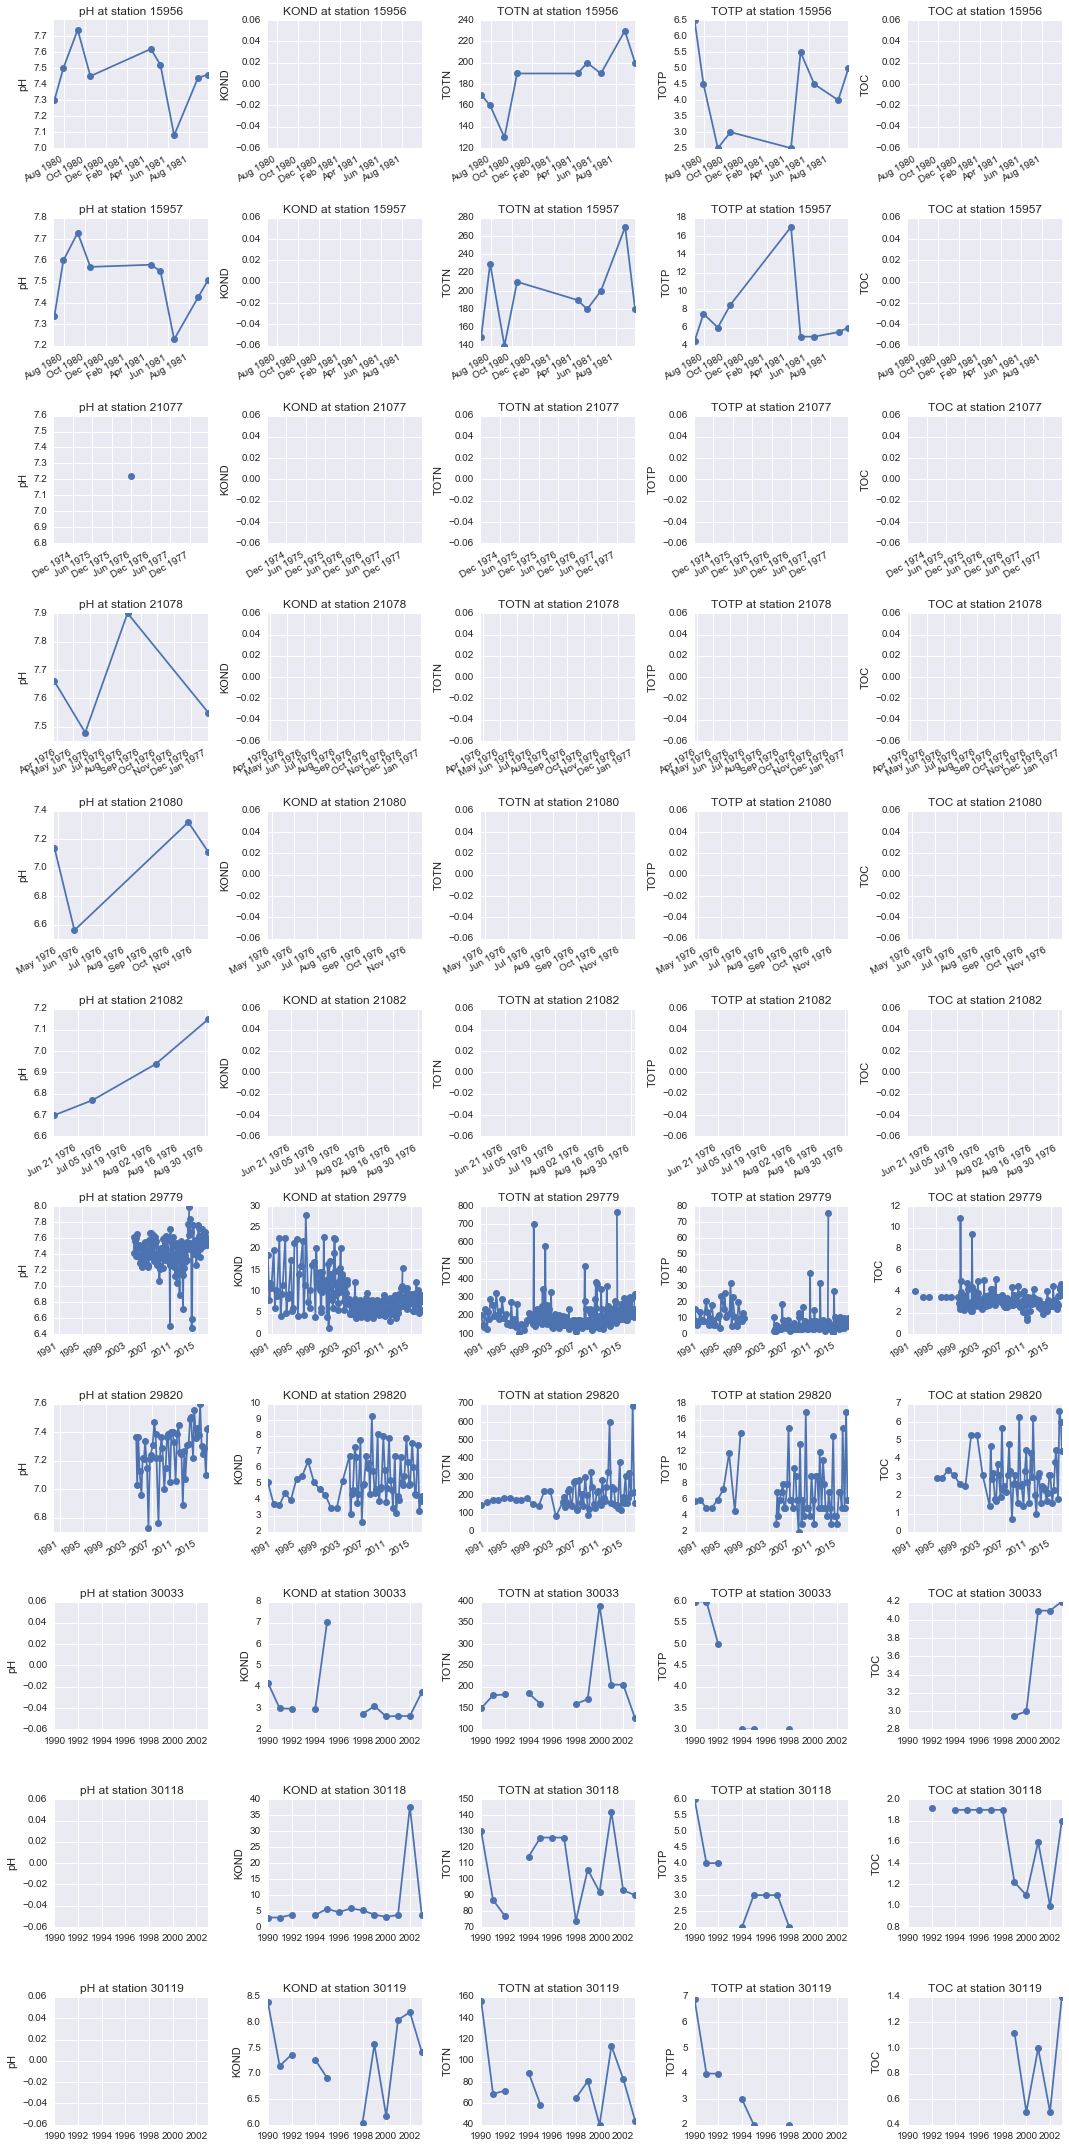

In [20]:
# Restructure df
var_list = ['pH', 'KOND', 'TOTN', 'TOTP', 'TOC']
df = wc_df[['station_id', 'date'] + var_list]
df = pd.melt(df, 
             id_vars=['station_id', 'date'],
             value_vars=var_list)

# Get unique stns and vars
stn_list = df['station_id'].unique()

# Setup plotting grid
fig, axes = plt.subplots(nrows=len(stn_list), 
                         ncols=len(var_list),
                         sharex=False,
                         sharey=False,
                         figsize=(15, 30))

# Plot
for sidx, stn in enumerate(stn_list):
    for vidx, var in enumerate(var_list):
        # Get data for this subplot
        df2 = df.query('(station_id==@stn) & (variable==@var)')
        df2.index = df2['date']
        df2.sort_index(inplace=True)
        df2 = df2[['value']]
        
        # Plot
        df2.plot(ax=axes[sidx, vidx], legend=False, style='-o')
        
        # Tidy
        axes[sidx, vidx].set_xlabel('')
        axes[sidx, vidx].set_ylabel(var)
        axes[sidx, vidx].set_title('%s at station %s' % (var, stn))

plt.tight_layout()

## 5. Trends

Nikolai's e-mail (07/03/2017 at 16.38) mentions basic trend analysis. The simplest approach is probably to remove any seasonality by calculating **annual medians** and then try applying the [Theil-Sen method](https://en.wikipedia.org/wiki/Theil%E2%80%93Sen_estimator) to get a robust estimate of the slope, together with a [Mann-Kendall test](http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm) to estimate trend significance. The main issue with this is that many of the sites of interest don't have long enough time series for trend estimates to be meaningful. In fact, most of them have just a few years' worth of data, so trend estimates based on annual averages aren't really possible.

To calculate trends, I can re-use code I've written previously for Heleen's ICP Waters project.

In [21]:
# Import modified version of ICPW code
icpw_func_path = r'C:\Data\James_Work\Staff\Nikolai_F\Arctic_Data_RESA\Python\arctic_trends.py'

trends = imp.load_source('arctic_trends', icpw_func_path)

In [22]:
# Specify folder for plotting
out_fold = r'C:\Data\James_Work\Staff\Nikolai_F\Arctic_Data_RESA\trends_plots'

# File to save results to
out_xlsx = r'C:\Data\James_Work\Staff\Nikolai_F\Arctic_Data_RESA\arctic_trends_results.xlsx'

# Restructure df
var_list = ['pH', 'KOND', 'TOTN', 'TOTP', 'TOC']

# Get unique stns and vars
stn_list = wc_df['station_id'].unique()

# Container for output
df_list = []

# Loop over data
for sidx, stn in enumerate(stn_list):
    # Get data
    df = wc_df.query('station_id==@stn')
    df.index = df['date']
    df.sort_index(inplace=True)

    # Calculate annual medians
    df = df.resample('A').median()
    
    # Extract year col and reset index
    df['year'] = df.index.year
    df.reset_index(inplace=True)
    df = df[['station_id', 'year'] + var_list]

    # Calculate trends
    res_df = trends.wc_stats(df, plot=True, fold=out_fold)
    
    df_list.append(res_df)

# Combine results
res_df = pd.concat(df_list, axis=0)

# Write output
res_df.to_excel(out_xlsx, index=False)

res_df.head()

    Data series for pH at site 15956 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for TOTN at site 15956 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for TOTP at site 15956 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for pH at site 15957 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for TOTN at site 15957 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for TOTP at site 15957 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for pH at site 21078 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for TOTP at site 30033 has fewer than 10 non-null values. Significance estimates may be unreliable.
    Data series for TOC at site 30033 has fewer than 10 non-null values. Signi

,station_id,par_id,period,non_missing,n_start,n_end,mean,median,std_dev,mk_stat,norm_mk_stat,mk_p_val,mk_std_dev,trend,sen_slp
0,15956,pH,1980-1981,2,2,2,7.4675,7.4675,0.010607,-1.0,0.0,1.0,1.0,no trend,-0.015
1,15956,KOND,1980-1981,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15956,TOTN,1980-1981,2,2,2,182.5000,182.5000,24.748737,1.0,0.0,1.0,1.0,no trend,35.000
3,15956,TOTP,1980-1981,2,2,2,4.1250,4.1250,0.530330,1.0,0.0,1.0,1.0,no trend,0.750
4,15956,TOC,1980-1981,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
